# Strong Lensing Challenge - Regression

Since its discovery via its gravitational interactions over half a century ago, the identity of dark matter has yet to be found. This is despite countless experiments aimed at detection of the most promising dark matter candidates. An alternative to terrestial detection (for example, with colliders or liquid xenon) for dark matter identification is unique gravitational signatures which arise from disparte substructure predicitions among dark matter models. Example substructures include subhalos of WIMP-like cold dark matter and vortices of superfluid dark matter. Perhaps the most promising method to infer the unique morphology of these substructures is with strong galaxy-galaxy lensing images; an intermediate dark matter halo (which contains a visible galaxy) lenses a galaxy which is behind it.

In this challenge we will use regression to measure the total fraction of mass in substructure of a dark matter halo. We will do so utilizing simulated strong lensing images with subahlo substructure consistent with non-interacting cold dark matter models.

In this notebook, we present a simple model implemented using the PyTorch library to solve a regression task for strong lensing images. Specifically, the task is to learn the total fraction of mass in substructure of a dark matter halo, i.e. $f_{sub} = m_{sub}/m_{halo}$ where $m_{sub}$ is the mass in substructure and $m_{halo}$ is the mass of the dark matter halo.

### Dataset

The dataset consists of *simulated* strong lensing images with cold dark matter subhalos generated by PyAutoLens. It contains 25k grayscale images with the size of 150x150 and the corresponding $f_{sub}$ which is known from simulations and should be $\sim \mathcal{O}(1\%)$.


### Evaluation Metric

* MAE (Mean Absolute Error)

### Instructions for using the notebook

1. Use GPU acceleration: (Edit --> Notebook settings --> Hardware accelerator --> GPU)
2. Run the cells: (Runtime --> Run all)



## Download Dataset

In [ ]:
!gdown http://drive.google.com/uc?id=116CeSrmcwIBWxnP-s0F2jDa6yS1BFINq
!tar zxvf data.tgz

In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

## Load Dataset

In [ ]:
DATASET_PATH = './data_sets/lens_data'
images = []
# f_sub -> mass fraction
f_subs = []
for f_name in os.listdir(DATASET_PATH):
  img, mass = np.load(os.path.join(DATASET_PATH,f_name),allow_pickle=True)
  # Add img and mass to separate lists
  # Add 1 as the first dimension for image
  images.append(img.reshape(1,img.shape[0],img.shape[1]))
  # Convert mass to a single element array with (1,1) dimensions
  f_subs.append(np.array(mass,ndmin=1))

# Images shape is (num_of_images,1,150,150)
images = np.stack(images).astype('float32')
# Mass fractions shape is (num_of_images,1)
f_subs = np.stack(f_subs).astype('float32')


## Plot Strong Lensing Images

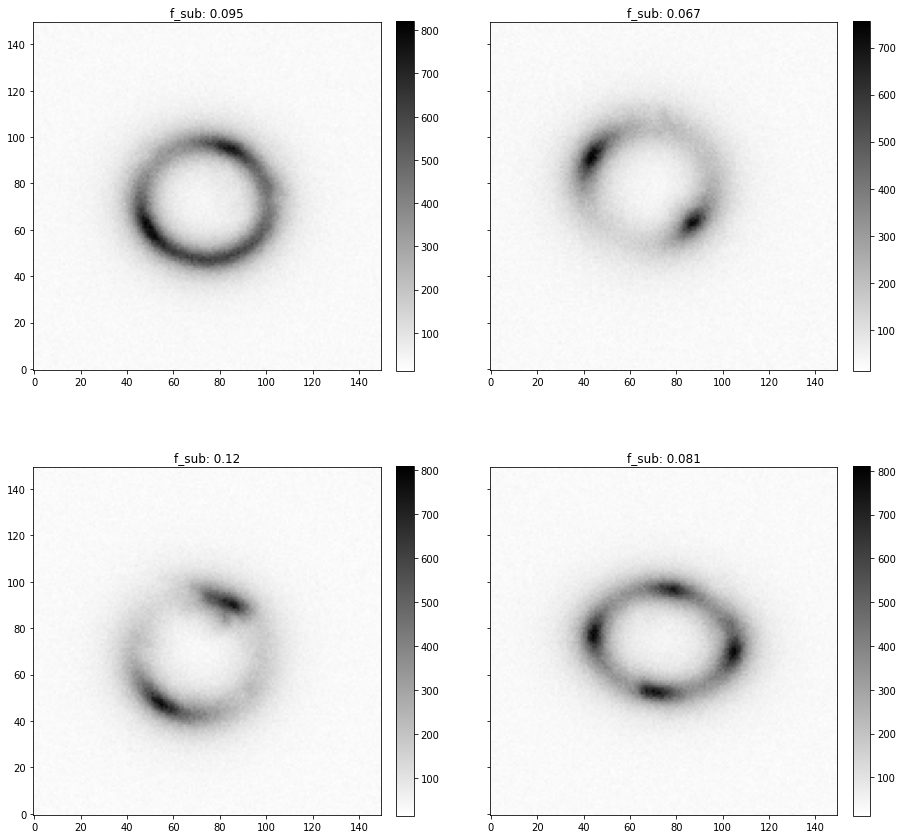

In [ ]:
# Will plot only first 4 lenses 
grid_size = (2,2)
figure,axis = plt.subplots(grid_size[0],grid_size[1],figsize=(15,15),sharey=True)
img_indx=0

for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    # Plotting image
    img = axis[i][j].imshow(images[img_indx][0], cmap='binary', origin='lower')
    # Setting up a title
    axis[i][j].set_title(f'f_sub: {f_subs[img_indx][0]:.2}')
    # Plotting a colorbar to show the intensity of pixels
    plt.colorbar(img,ax=axis[i][j],fraction=0.046, pad=0.04)

    img_indx+=1
plt.show()

## Standardization


In [ ]:
# Applies z-standartization to make the dataset mean=0 and std=1
def standardize(element,STD,MEAN):
    return (element - MEAN) / STD
# Cancel the effect of z-standartization
def inv_standardize(element,STD,MEAN):
    return element * STD + MEAN

# Find stats of the dataset
IMAGES_MEAN, IMAGES_STD = images.mean(), images.std()
F_SUB_MEAN, F_SUB_STD = f_subs.mean(), f_subs.std()

# Standardize the dataset
images=standardize(images,IMAGES_STD,IMAGES_MEAN)
f_subs=standardize(f_subs,F_SUB_STD,F_SUB_MEAN)

## Create Custom Dataset

In [ ]:
class RegressionNumpyArrayDataset(Dataset):
  def __init__(self,x,y,indexes=None,x_transforms_func = None):

    self.x = x[indexes]
    self.y = y[indexes]

    # Transforms that will be aplied to the every batch of lenses.
    # x_transforms_func must be callable.
    self.x_transforms = x_transforms_func


  def __len__(self):
    # Returns the length of the dataset
    return self.x.shape[0]

  def __getitem__(self, idx):
    # Returns an (image, label) tuple
    image, label = self.x[idx], self.y[idx]
    
    # Convert to Tensor and Float
    image = torch.tensor(image).float()
    label = torch.tensor(label).float()

    # Apply transforms
    if self.x_transforms!=None:
      image= self.x_transforms(image)


    return  image , label 

## Split Dataset

In [ ]:
train_indx = np.arange(0,15000)#np.arange(0,13000)
test_indx = np.arange(15000,20000)

## Image Augmentation

In [ ]:
base_image_transforms = transforms.Compose([
    transforms.Resize(150)
])

In [ ]:
# Create instanses of test and train datasets
train_dataset = RegressionNumpyArrayDataset(images, f_subs, train_indx,
                                            base_image_transforms)
test_dataset = RegressionNumpyArrayDataset(images, f_subs, test_indx,                                 
                                           base_image_transforms)

# Create instanses of dataloaders
batch_size = 64

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Regression Models

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        # Flat dimensions before applying the linear layer
        flatten_x = torch.flatten(x,start_dim=1)
        out = self.linear(flatten_x)
        return out

class Resnet18Regression(torch.nn.Module):
    def __init__(self, num_of_input_channels, output_size):
        super(Resnet18Regression, self).__init__()
        self.resnet18 = torchvision.models.resnet18()
        # Change the input number of channels to 1 to make it work on grayscale images
        self.resnet18.conv1 = torch.nn.Conv2d(num_of_input_channels, 64, kernel_size=(7, 7), 
                                 stride=(2, 2), padding=(3, 3), bias=False)
        # Change the output size to 1 to predict a mass density
        self.resnet18.fc = torch.nn.Linear(in_features=512, out_features=output_size, 
                                           bias=True)

    def forward(self, x):
        out = self.resnet18(x)
        return out

## Loss Function

In [ ]:
def mse_loss(pred, true):
    loss = (pred-true).pow(2)
    return loss.mean()

## Training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

# Create an instanse of the model.
# 150*150 = 22500
#model = LinearRegression(22500,1).to(device)
model = Resnet18Regression(1,1).to(device)

Device: cuda


In [ ]:
# Optimizer
lr = 1e-2
weight_decay = 0
num_of_epochs = 35

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
# Start the training loop
for i in range(num_of_epochs):
  epoch_loss = 0
  num_of_steps_in_epoch = 0
  for step, (images_batch, f_subs_batch) in enumerate(train_data_loader):
    optimizer.zero_grad()

    # Use GPU if available
    if torch.cuda.is_available():
      images_batch = images_batch.cuda()
      f_subs_batch = f_subs_batch.cuda()

    # RUN the model
    predicted_f_subs = model(images_batch)
    
    # Calculate loss
    loss = mse_loss(predicted_f_subs,f_subs_batch)

    # Calculate gradient
    loss.backward()
    # Do an optimization step
    optimizer.step()

    
    epoch_loss+=loss
    num_of_steps_in_epoch+=1
  
  loss_w = (epoch_loss/num_of_steps_in_epoch).detach().item()
  print(f'Epoch {i+1} loss is: {loss_w}')
  

Epoch 1 loss is: 1.4228554964065552
Epoch 2 loss is: 1.0350960493087769
Epoch 3 loss is: 0.9426213502883911
Epoch 4 loss is: 0.8270425200462341
Epoch 5 loss is: 0.7284778952598572
Epoch 6 loss is: 0.6408405900001526
Epoch 7 loss is: 0.5996803045272827
Epoch 8 loss is: 0.5323775410652161
Epoch 9 loss is: 0.5164577960968018
Epoch 10 loss is: 0.4633411467075348
Epoch 11 loss is: 0.45104658603668213
Epoch 12 loss is: 0.43933573365211487
Epoch 13 loss is: 0.4114443361759186
Epoch 14 loss is: 0.4037425220012665
Epoch 15 loss is: 0.4026414752006531
Epoch 16 loss is: 0.3823660910129547
Epoch 17 loss is: 0.38644492626190186
Epoch 18 loss is: 0.37324899435043335
Epoch 19 loss is: 0.3698246479034424
Epoch 20 loss is: 0.35835397243499756
Epoch 21 loss is: 0.3582046329975128
Epoch 22 loss is: 0.3518848419189453
Epoch 23 loss is: 0.342626690864563
Epoch 24 loss is: 0.3338993191719055
Epoch 25 loss is: 0.33255094289779663
Epoch 26 loss is: 0.3351556658744812
Epoch 27 loss is: 0.33099597692489624
Epoc

## Testing

In [ ]:
# Run the model on the test dataset
predicted_f_subs_list = []
real_f_subs_list = []
for step, (images, f_subs) in enumerate(test_data_loader):
    # Use GPU if available
    if torch.cuda.is_available():
      images = images.cuda()
      f_subs = f_subs.cuda()

    # RUN the model
    predicted_f_subs = model(images)
    predicted_f_subs_list.append(predicted_f_subs.cpu().detach().numpy())
    real_f_subs_list.append(f_subs.cpu().numpy())


# Remove the last batch of the results to make all the arrays in the list the same size
del predicted_f_subs_list[-1]
del real_f_subs_list[-1]

In [ ]:
# Mean Absolute Error is used as the main metric for measuring the performance of the model.
def mae_loss(pred, true):
    loss = np.abs(pred-true)
    return loss.mean()

## Plot the results

MAE: 0.01015949621796608


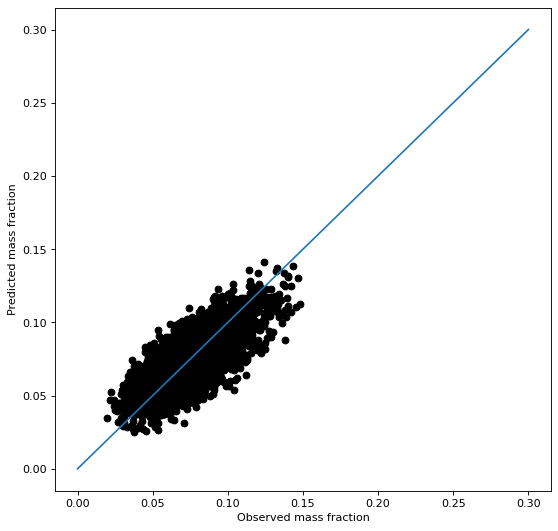

In [ ]:
# PLOTTING TEST RESULTS
predicted_f_subs_arr = np.concatenate(predicted_f_subs_list)
real_f_subs_arr = np.concatenate(real_f_subs_list)

m_pred,m_true = inv_standardize(predicted_f_subs_arr,F_SUB_STD,F_SUB_MEAN),inv_standardize(real_f_subs_arr,F_SUB_STD,F_SUB_MEAN)



test_mae = mae_loss(m_pred,m_true)
plt.figure(figsize=(8,8),dpi=80)
plt.scatter(m_true, m_pred,  color='black')
line = np.linspace(0, 0.3, 10)
plt.plot(line, line)
plt.xlabel('Observed mass fraction')
plt.ylabel('Predicted mass fraction')
print(f'MAE: {test_mae}')
#plt.text(1,4, 'MAE: {:.4f}'.format(test_mae))



## Save the model

In [ ]:
SAVE_PATH = './best_model'
torch.save(model.state_dict(), SAVE_PATH)

## Submission Guidelines 

* You are required to submit a Google Colab Jupyter Notebook clearly showing your implementation along with the evaluation metrics (MAE) for the training and validation data.
* You also have to submit the final trained model, including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. )
* You can use this example notebook as a template for your work.
+ The model performance will be evaluated on the hidden dataset based on the above metrics. 

> **_NOTE:_**  You are free to use any ML framework such as PyTorch, Keras, TensorFlow, etc.